In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
from matplotlib.colors import LogNorm

from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### global settings and helper functions

In [3]:
FIG_WIDTH = 10
FONTSIZE = 14
FONTSIZE_LEGEND = 12

TR_COLOR = (0.7, 0.7, 0.7)
LR_COLOR = 'royalblue'
LR_COLOR_FILL = 'cornflowerblue'
HR_COLOR = (0.67, 0.31, 0.39)
HR_COLOR_FILL = (0.96, 0.44, 0.56)

### Files to compare

In [4]:
low_fp = 'path_to_low_pred.root'
high_fp = 'path_to_high_pred.root'

In [5]:
f_low = uproot.open(low_fp)
low_dict = {
    'truth_pt_raw' : f_low['Particle_Tree']['truth_pt_raw'].array(library='np'),
    'truth_eta_raw': f_low['Particle_Tree']['truth_eta_raw'].array(library='np'),
    'truth_phi'    : f_low['Particle_Tree']['truth_phi'].array(library='np'),
    'truth_e_raw'  : f_low['Particle_Tree']['truth_e_raw'].array(library='np'),
    'truth_dep_e_raw' : f_low['Particle_Tree']['truth_dep_e_raw'].array(library='np'), # 'truth_dep_e_raw

    'pred_pt_raw' : f_low['Particle_Tree']['pred_pt_raw'].array(library='np'),
    'pred_eta_raw': f_low['Particle_Tree']['pred_eta_raw'].array(library='np'),
    'pred_phi'    : f_low['Particle_Tree']['pred_phi'].array(library='np'),
    'pred_e_raw'  : f_low['Particle_Tree']['pred_e_raw'].array(library='np'),

    'truth_card'  : f_low['Particle_Tree']['truth_card'].array(library='np'),
    'pred_card'   : f_low['Particle_Tree']['pred_card'].array(library='np'),
}

f_high = uproot.open(high_fp)
high_dict = {
    'truth_pt_raw' : f_high['Particle_Tree']['truth_pt_raw'].array(library='np'),
    'truth_eta_raw': f_high['Particle_Tree']['truth_eta_raw'].array(library='np'),
    'truth_phi'    : f_high['Particle_Tree']['truth_phi'].array(library='np'),
    'truth_e_raw'  : f_high['Particle_Tree']['truth_e_raw'].array(library='np'),
    'truth_dep_e_raw' : f_high['Particle_Tree']['truth_dep_e_raw'].array(library='np'), # 'truth_dep_e_raw'

    'pred_pt_raw' : f_high['Particle_Tree']['pred_pt_raw'].array(library='np'),
    'pred_eta_raw': f_high['Particle_Tree']['pred_eta_raw'].array(library='np'),
    'pred_phi'    : f_high['Particle_Tree']['pred_phi'].array(library='np'),
    'pred_e_raw'  : f_high['Particle_Tree']['pred_e_raw'].array(library='np'),

    'truth_card'  : f_high['Particle_Tree']['truth_card'].array(library='np'),
    'pred_card'   : f_high['Particle_Tree']['pred_card'].array(library='np'),
}

### Transformation : $\phi \rightarrow \left[ -\pi, +\pi \right]$

In [6]:
for i, phis in enumerate(low_dict['pred_phi']):
    phis = (phis + np.pi) % (2 * np.pi) - np.pi
    low_dict['pred_phi'][i] = phis

for i, phis in enumerate(high_dict['pred_phi']):
    phis = (phis + np.pi) % (2 * np.pi) - np.pi
    high_dict['pred_phi'][i] = phis

### Cardinality

In [7]:
del_card_low = low_dict['truth_card'] - low_dict['pred_card']
del_card_high = high_dict['truth_card'] - high_dict['pred_card']

#### Table

In [8]:
correct_percentage_low = []; correct_percentage_high = []
for card_i in [1, 2, 3, 4]:
    low_mask = low_dict['truth_card'] == card_i
    low_perc = np.sum(del_card_low[low_mask] == 0) / len(del_card_low[low_mask]) * 100
    correct_percentage_low.append(low_perc)

    high_mask = high_dict['truth_card'] == card_i
    high_perc = np.sum(del_card_high[high_mask] == 0) / len(del_card_high[high_mask]) * 100
    correct_percentage_high.append(high_perc)

print( '+-------------+---------+---------+')
print( '|    Truth    |         |         |')
print( '| cardinality | LR acc. | HR acc. |')
print( '+-------------+---------+---------+')
for i in range(4):
    print( f'|          {i+1}  | {correct_percentage_low[i]:.2f} % | {correct_percentage_high[i]:.2f} % |')
print( '+-------------+---------+---------+')

+-------------+---------+---------+
|    Truth    |         |         |
| cardinality | LR acc. | HR acc. |
+-------------+---------+---------+
|          1  | 99.38 % | 99.41 % |
|          2  | 88.52 % | 91.02 % |
|          3  | 77.62 % | 81.97 % |
|          4  | 81.32 % | 81.42 % |
+-------------+---------+---------+


##### For latex

In [9]:
for i in range(4):
    print( f'\t{i+1} & {correct_percentage_low[i]:.2f} \% & {correct_percentage_high[i]:.2f} \% \\\ \hline')


	1 & 99.38 \% & 99.41 \% \\ \hline
	2 & 88.52 \% & 91.02 \% \\ \hline
	3 & 77.62 \% & 81.97 \% \\ \hline
	4 & 81.32 \% & 81.42 \% \\ \hline


### Kinematics

In [11]:
residual_dict_low = {
    'pt': np.hstack(low_dict['pred_pt_raw']) - np.hstack(low_dict['truth_pt_raw']),
    'eta': np.hstack(low_dict['pred_eta_raw']) - np.hstack(low_dict['truth_eta_raw']),
    'phi': np.hstack(low_dict['pred_phi']) - np.hstack(low_dict['truth_phi']),
    'e': np.hstack(low_dict['pred_e_raw']) - np.hstack(low_dict['truth_e_raw']),
    'dep_e': np.hstack(low_dict['pred_e_raw']) - np.hstack(low_dict['truth_dep_e_raw']),
}

residual_dict_high = {
    'pt': np.hstack(high_dict['pred_pt_raw']) - np.hstack(high_dict['truth_pt_raw']),
    'eta': np.hstack(high_dict['pred_eta_raw']) - np.hstack(high_dict['truth_eta_raw']),
    'phi': np.hstack(high_dict['pred_phi']) - np.hstack(high_dict['truth_phi']),
    'e': np.hstack(high_dict['pred_e_raw']) - np.hstack(high_dict['truth_e_raw']),
    'dep_e': np.hstack(high_dict['pred_e_raw']) - np.hstack(high_dict['truth_dep_e_raw']),
}

rel_residual_dict_low = {
    'pt': np.hstack(low_dict['pred_pt_raw']) / np.hstack(low_dict['truth_pt_raw']) - 1,
    'eta': np.hstack(low_dict['pred_eta_raw']) / np.hstack(low_dict['truth_eta_raw']) - 1,
    'phi': np.hstack(low_dict['pred_phi']) / np.hstack(low_dict['truth_phi']) - 1,
    'e': np.hstack(low_dict['pred_e_raw']) / np.hstack(low_dict['truth_e_raw']) - 1,
    'dep_e': np.hstack(low_dict['pred_e_raw']) / np.hstack(low_dict['truth_dep_e_raw']) - 1,
}

rel_residual_dict_high = {
    'pt': np.hstack(high_dict['pred_pt_raw']) / np.hstack(high_dict['truth_pt_raw']) - 1,
    'eta': np.hstack(high_dict['pred_eta_raw']) / np.hstack(high_dict['truth_eta_raw']) - 1,
    'phi': np.hstack(high_dict['pred_phi']) / np.hstack(high_dict['truth_phi']) - 1,
    'e': np.hstack(high_dict['pred_e_raw']) / np.hstack(high_dict['truth_e_raw']) - 1,
    'dep_e': np.hstack(high_dict['pred_e_raw']) / np.hstack(high_dict['truth_dep_e_raw']) - 1,
}

/tmp/ipykernel_195914/4266523186.py:22: RuntimeWarning: divide by zero encountered in divide
  'dep_e': np.hstack(low_dict['pred_e_raw']) / np.hstack(low_dict['truth_dep_e_raw']) - 1,
/tmp/ipykernel_195914/4266523186.py:30: RuntimeWarning: divide by zero encountered in divide
  'dep_e': np.hstack(high_dict['pred_e_raw']) / np.hstack(high_dict['truth_dep_e_raw']) - 1,


In [12]:
def get_label(x, md=2, sd=2):
    _mean = np.mean(x)
    _std = np.std(x)

    return f'  $\mu$ = {_mean:>5.{md}f}, $\sigma$ = {_std:>3.{sd}f}'

In [13]:
def plot_residual(low_vals, high_vals, _min, _max, xlabel, fontsize):
    fig = plt.figure(figsize=(FIG_WIDTH/2, 0.4*FIG_WIDTH), dpi=300)
    gs = fig.add_gridspec(1, 1)

    ax = fig.add_subplot(gs[0])
    comb = np.concatenate([low_vals, high_vals])
    bins = np.linspace(_min, _max, 80)
    ax.hist(low_vals, bins=bins, histtype='stepfilled', color=LR_COLOR_FILL, alpha=0.9, zorder=10,
        label=f'LR {get_label(low_vals)}')
    ax.hist(high_vals, bins=bins, histtype='step', color=HR_COLOR, zorder=10,
        label=f'HR {get_label(high_vals)}')
    ax.set_xlabel(xlabel, fontsize=fontsize)

    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, left=True, right=True)
    ax.legend(fontsize=FONTSIZE_LEGEND, frameon=False)
    ax.set_ylim(0, 1.4*ax.get_ylim()[1])

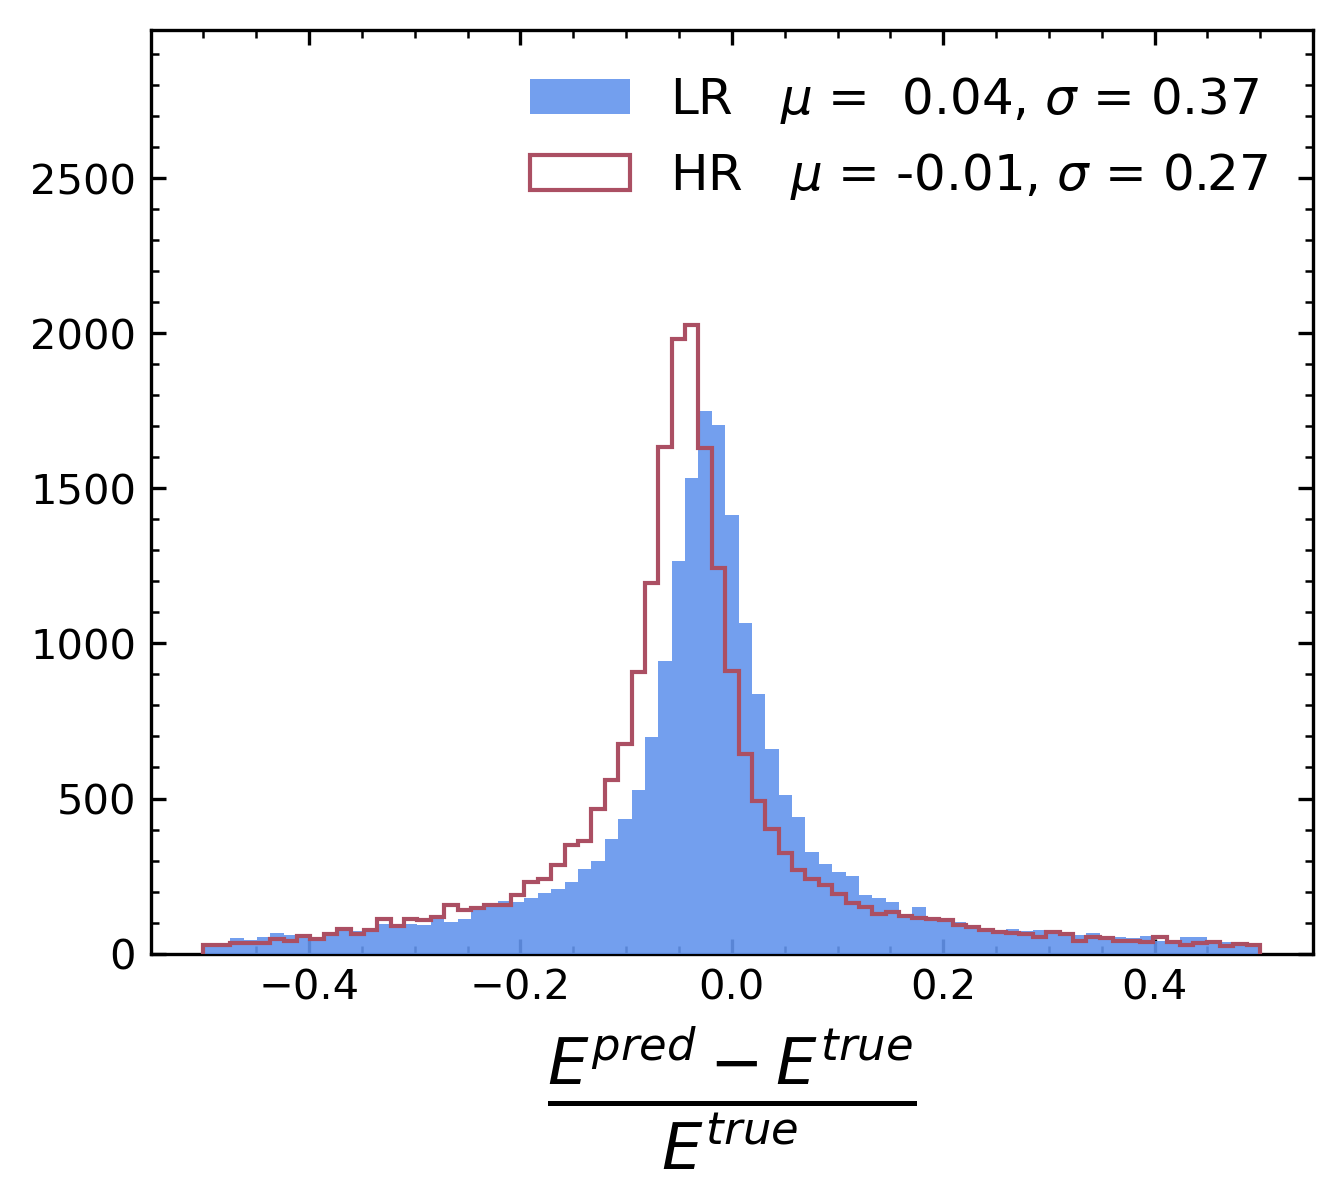

In [23]:
plot_residual(rel_residual_dict_low['e'], rel_residual_dict_high['e'], -0.5, 0.5, r'$\frac{E^{pred} - E^{true}}{E^{true}}$', 22)

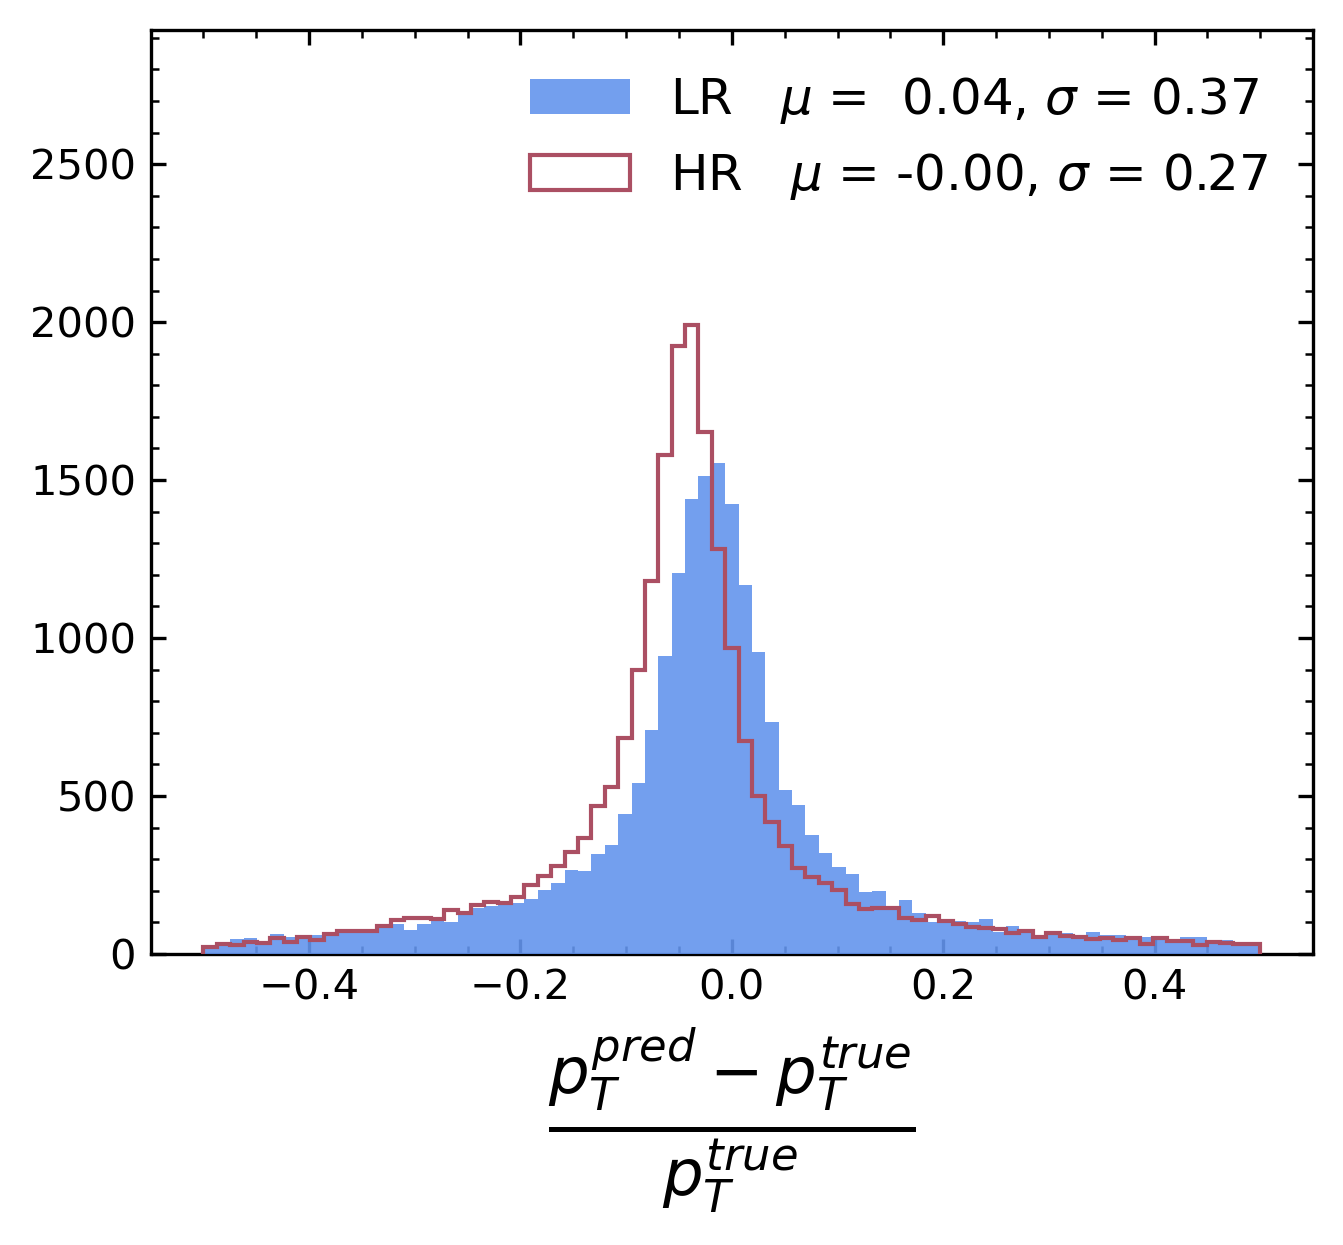

In [17]:
plot_residual(rel_residual_dict_low['pt'], rel_residual_dict_high['pt'], -0.5, 0.5, r'$\frac{p_T^{pred} - p_T^{true}}{p_T^{true}}$', 22)

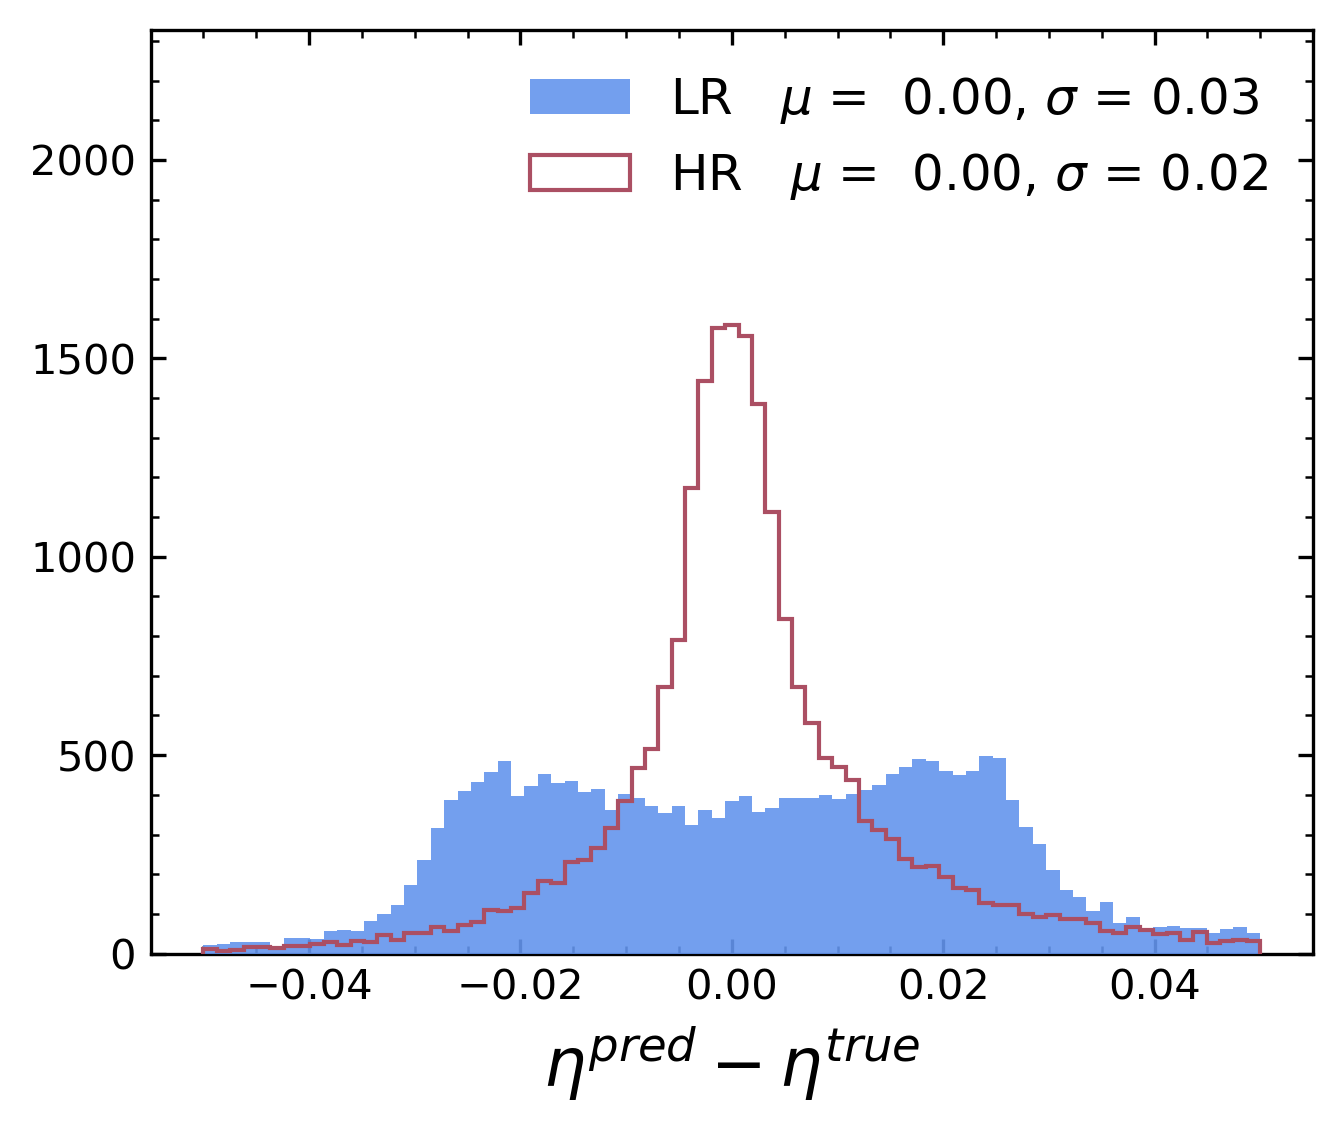

In [21]:
plot_residual(residual_dict_low['eta'], residual_dict_high['eta'], -0.05, 0.05, r'$\eta^{pred} - \eta^{true}$', 16)

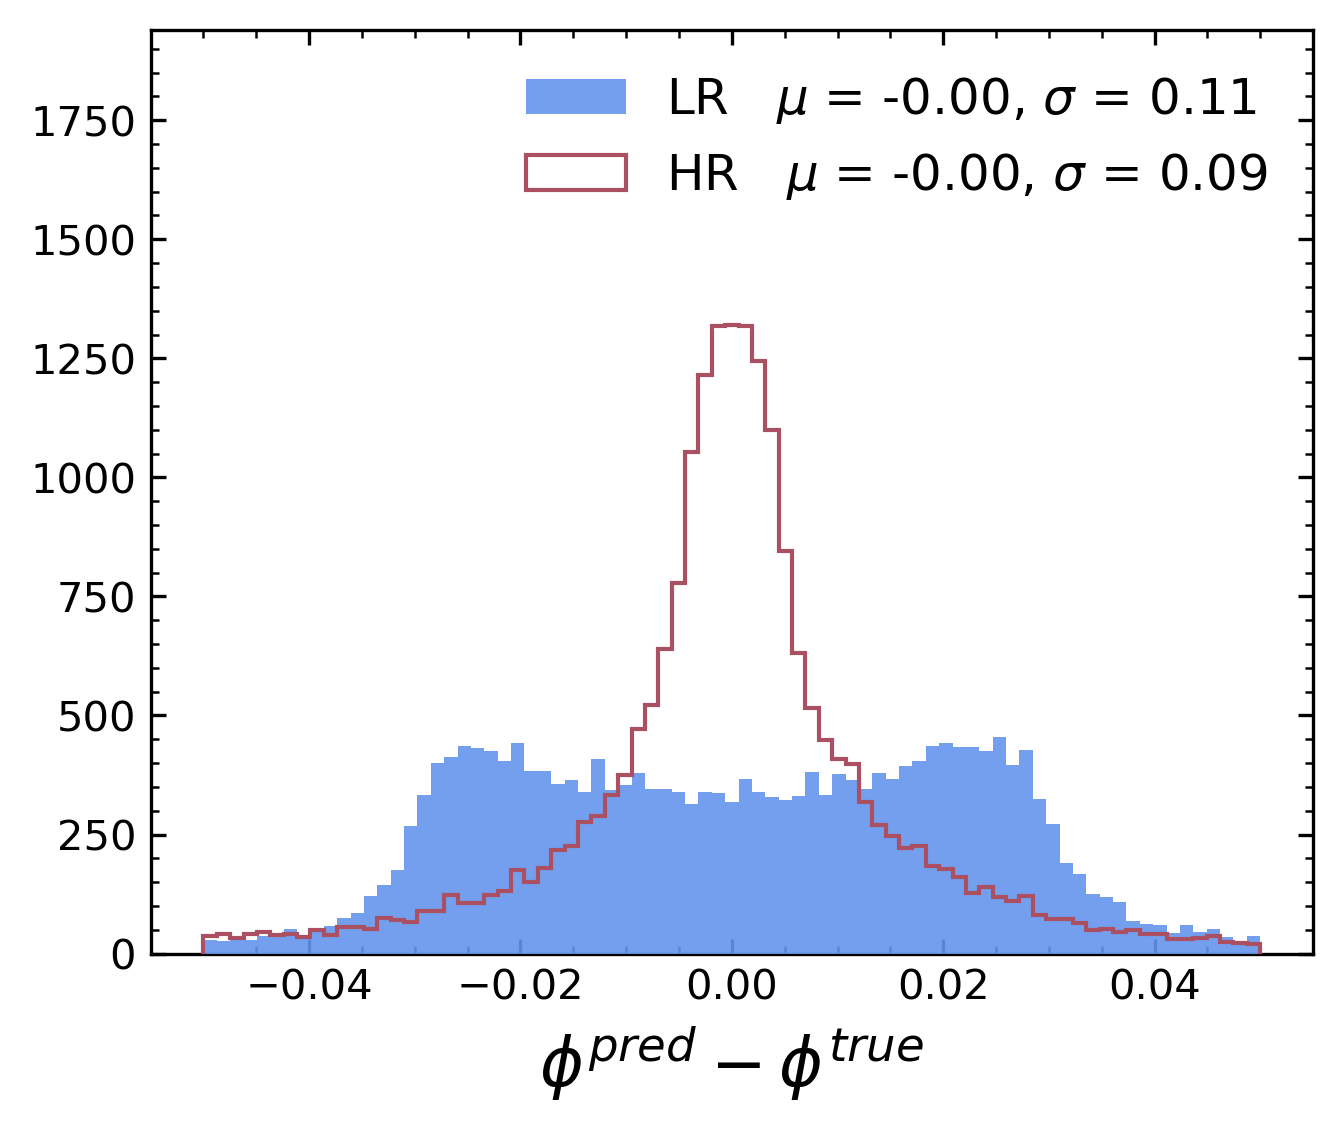

In [22]:
plot_residual(residual_dict_low['phi'], residual_dict_high['phi'], -0.05, 0.05, r'$\phi^{pred} - \phi^{true}$', 16)

### $\eta$ (same with $\phi$) residual shape investigation

In [42]:
low_pred_eta_flat = np.hstack(low_dict['pred_eta_raw'])
low_truth_eta_flat = np.hstack(low_dict['truth_eta_raw'])

high_pred_eta_flat = np.hstack(high_dict['pred_eta_raw'])
high_truth_eta_flat = np.hstack(high_dict['truth_eta_raw'])


low_pred_phi_flat = np.hstack(low_dict['pred_phi'])
low_truth_phi_flat = np.hstack(low_dict['truth_phi'])

high_pred_phi_flat = np.hstack(high_dict['pred_phi'])
high_truth_phi_flat = np.hstack(high_dict['truth_phi'])

Text(0, 0.5, '$\\Delta \\phi$')

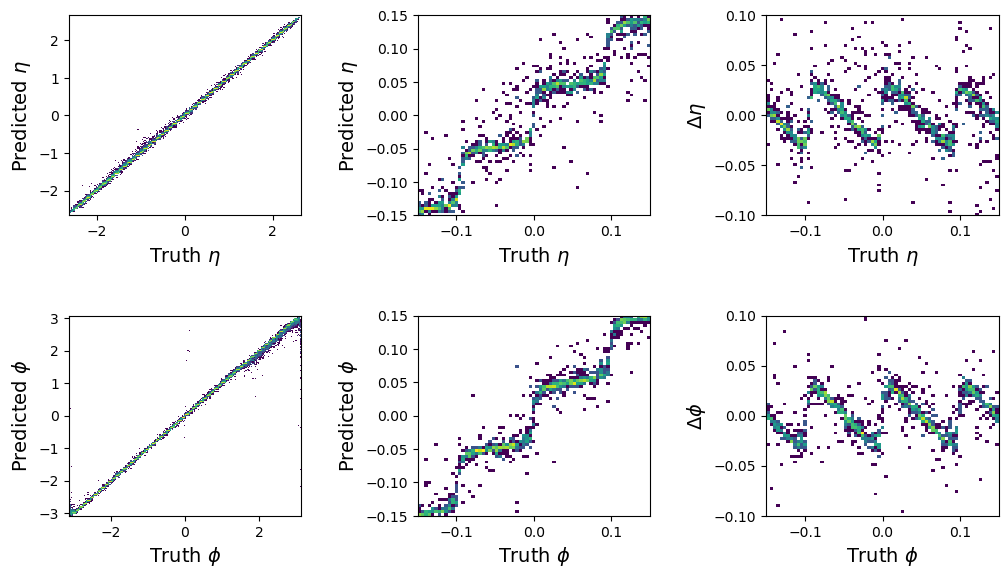

In [44]:
fig = plt.figure(figsize=(12, 6.5))
gs = fig.add_gridspec(2, 3, wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(gs[0])
ax1.hist2d(low_truth_eta_flat, low_pred_eta_flat, bins=200, cmap='viridis', norm=LogNorm())

ax2 = fig.add_subplot(gs[1])
ax2.hist2d(low_truth_eta_flat, low_pred_eta_flat, bins=np.linspace(-0.15, 0.15, 70), cmap='viridis', norm=LogNorm())

for ax in [ax1, ax2]:
    ax.set_xlabel(r'Truth $\eta$', fontsize=FONTSIZE)
    ax.set_ylabel(r'Predicted $\eta$', fontsize=FONTSIZE)

ax3 = fig.add_subplot(gs[2])
xbins = np.linspace(-0.15, 0.15, 70); ybins = np.linspace(-0.1, 0.1, 70)
ax3.hist2d(low_truth_eta_flat, low_pred_eta_flat - low_truth_eta_flat, bins=[xbins, ybins], cmap='viridis', norm=LogNorm())
ax3.set_xlabel(r'Truth $\eta$', fontsize=FONTSIZE)
ax3.set_ylabel(r'$\Delta \eta$', fontsize=FONTSIZE)


ax4 = fig.add_subplot(gs[3])
ax4.hist2d(low_truth_phi_flat, low_pred_phi_flat, bins=200, cmap='viridis', norm=LogNorm())

ax5 = fig.add_subplot(gs[4])
ax5.hist2d(low_truth_phi_flat, low_pred_phi_flat, bins=np.linspace(-0.15, 0.15, 70), cmap='viridis', norm=LogNorm())

for ax in [ax4, ax5]:
    ax.set_xlabel(r'Truth $\phi$', fontsize=FONTSIZE)
    ax.set_ylabel(r'Predicted $\phi$', fontsize=FONTSIZE)

ax6 = fig.add_subplot(gs[5])
xbins = np.linspace(-0.15, 0.15, 70); ybins = np.linspace(-0.1, 0.1, 70)
ax6.hist2d(low_truth_phi_flat, low_pred_phi_flat - low_truth_phi_flat, bins=[xbins, ybins], cmap='viridis', norm=LogNorm())
ax6.set_xlabel(r'Truth $\phi$', fontsize=FONTSIZE)
ax6.set_ylabel(r'$\Delta \phi$', fontsize=FONTSIZE)

### Tiny analysis

- Main difference wrt HGPflow - cells are in a grid, topoclusters are not

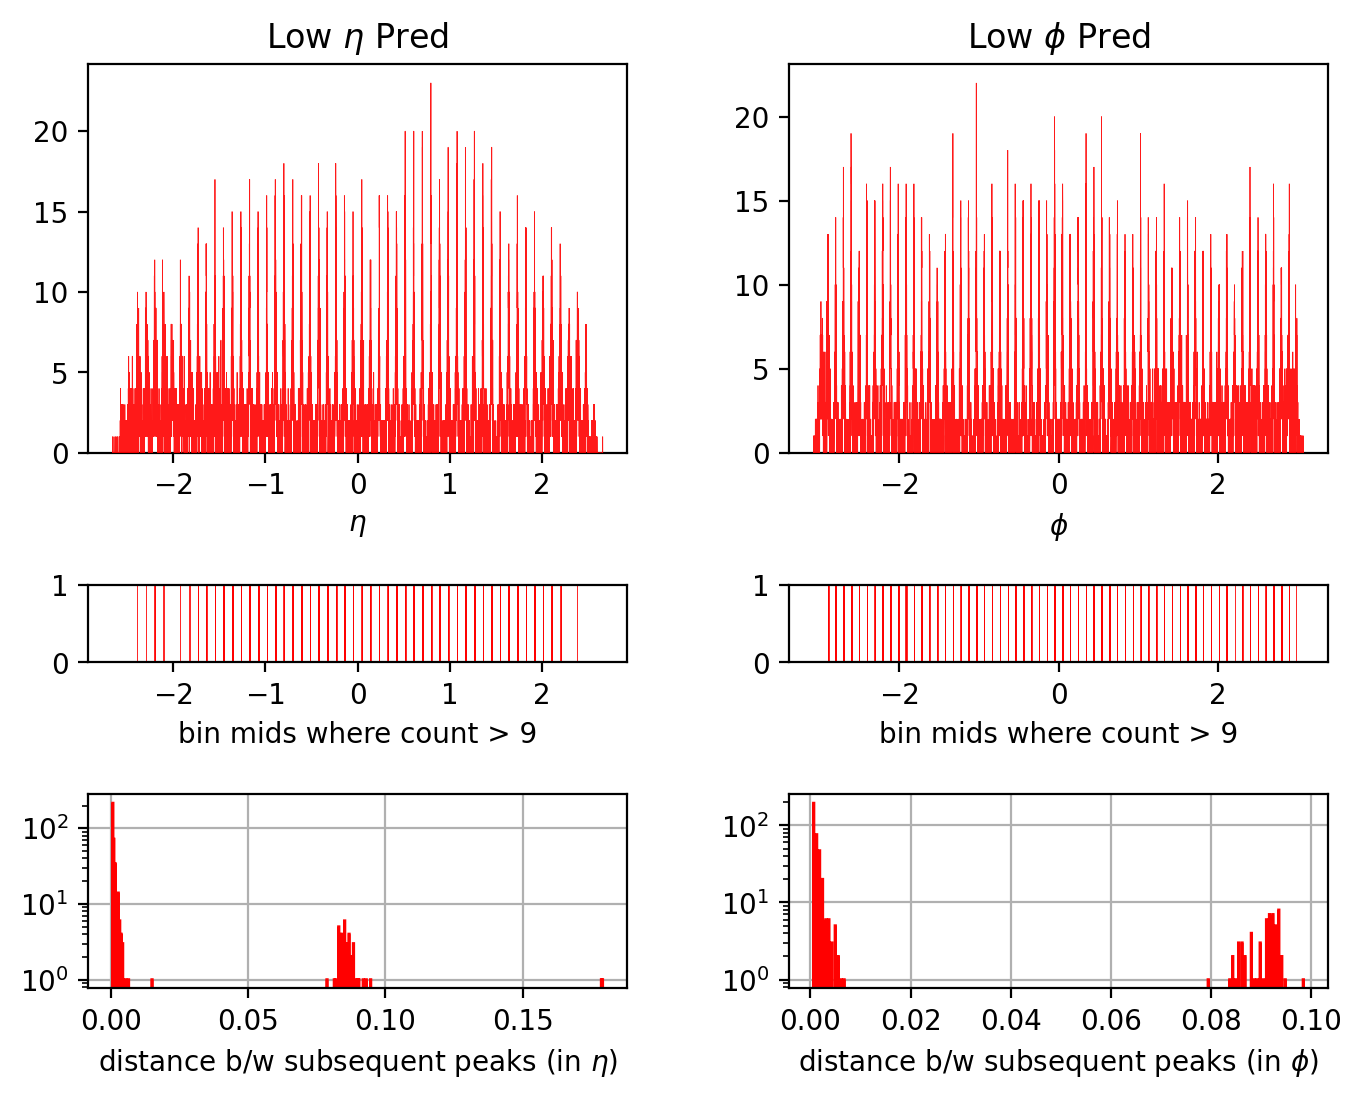

In [45]:
fig = plt.figure(figsize=(8, 6), dpi=200)
gs = fig.add_gridspec(3, 2, wspace=0.3, hspace=0.6, height_ratios=[1, 0.2, 0.5])

bins = 10_000

for i, (name, var) in enumerate(zip(['eta', 'phi'],[low_pred_eta_flat, low_pred_phi_flat])):

    ax1 = fig.add_subplot(gs[0, i])
    hl, xl, _ = ax1.hist(var, bins=bins, histtype='step', color='red', alpha=0.9, zorder=10, ec='red', lw=0.3)
    ax1.set_xlabel(f'$\{name}$')
    ax1.set_title(f'Low $\{name}$ Pred')

    ax2 = fig.add_subplot(gs[1, i])
    mask = hl > 9
    xl_mid = 0.5 * (xl[1:] + xl[:-1])
    for x in xl_mid[mask]:
        ax2.axvline(x, color='red', lw=0.3)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel('bin mids where count > 9')

    ax3 = fig.add_subplot(gs[2, i])
    neighbor_dist = xl_mid[mask][1:] - xl_mid[mask][:-1]
    ax3.hist(neighbor_dist, bins=1000, histtype='step', color='red')
    ax3.set_xlabel(f'distance b/w subsequent peaks (in $\{name}$)')
    ax3.set_yscale('log')
    ax3.grid()

- at Low resolution, ECAL1 has 64 cells in both $\eta$ and $\phi$ directions
    - $\Delta \eta_{min} = 5/64 = 0.078$
    - $\Delta \phi_{min} = 2\pi/64 = 0.098$

- These values match the second peak seen above

### How about high resolution?

- at High resolution, ECAL1 has 256 cells in both $\eta$ and $\phi$ directions
    - $\Delta \eta_{min} = 5/256 = 0.0195$
    - $\Delta \phi_{min} = 2\pi/256 = 0.0245$


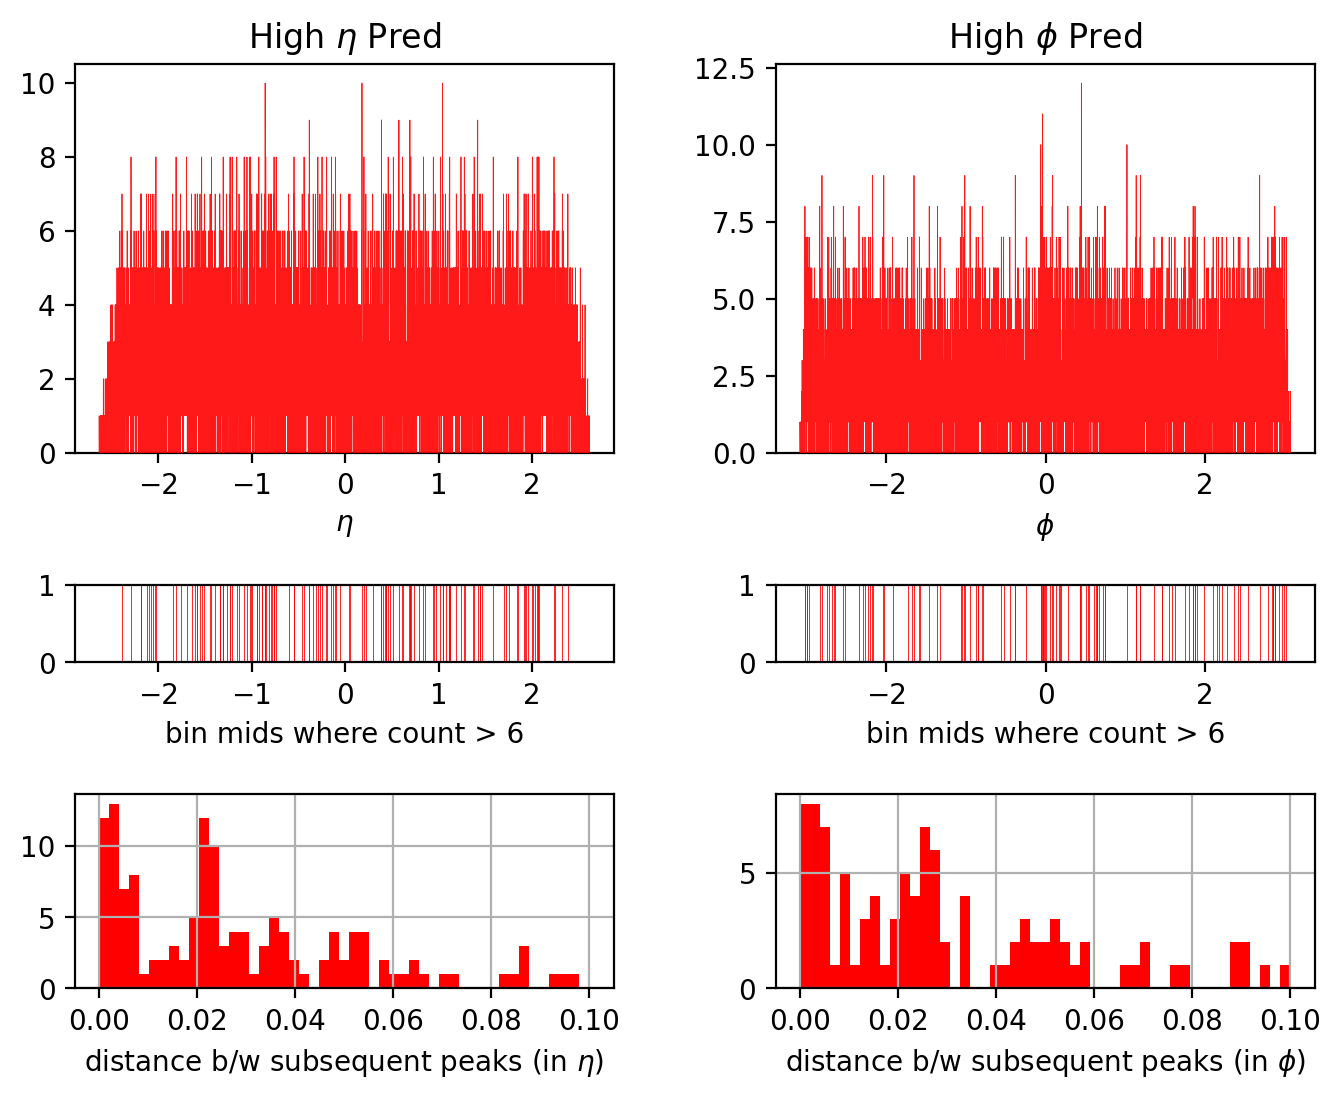

In [65]:
fig = plt.figure(figsize=(8, 6), dpi=200)
gs = fig.add_gridspec(3, 2, wspace=0.3, hspace=0.6, height_ratios=[1, 0.2, 0.5])

bins = 10_000

for i, (name, var) in enumerate(zip(['eta', 'phi'],[high_pred_eta_flat, high_pred_phi_flat])):

    ax1 = fig.add_subplot(gs[0, i])
    hl, xl, _ = ax1.hist(var, bins=bins, histtype='step', color='red', alpha=0.9, zorder=10, ec='red', lw=0.3)
    ax1.set_xlabel(f'$\{name}$')
    ax1.set_title(f'High $\{name}$ Pred')

    ax2 = fig.add_subplot(gs[1, i])
    mask = hl > 6
    xl_mid = 0.5 * (xl[1:] + xl[:-1])
    for x in xl_mid[mask]:
        ax2.axvline(x, color='red', lw=0.3)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel('bin mids where count > 6')

    ax3 = fig.add_subplot(gs[2, i])
    neighbor_dist = xl_mid[mask][1:] - xl_mid[mask][:-1]
    bins_ = np.linspace(0, 0.1, 50)
    ax3.hist(neighbor_dist, bins=bins_, histtype='stepfilled', color='red')
    ax3.set_xlabel(f'distance b/w subsequent peaks (in $\{name}$)')
    # ax3.set_yscale('log')
    ax3.grid()